In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/codes/G-ZZ/jl_files/zz_samplers.jl")

GibbsHMC (generic function with 3 methods)

In [2]:
function run_sampler(my_model, lambda, max_attempts, mb_size, Print=false, prob_het=0.98, adapt_speed="none") 
    
    d, Nobs = size(my_model.ll.X)
    
    # Define minibatch sampler list:
    gs = Array{mbsampler}(d)
    gs[1] = umbsampler(0, Nobs, mb_size)

    for i in 2:d
        weights_het = abs.(my_model.ll.X[i,:])./sum(abs.(my_model.ll.X[i,:]))
        if length(my_model.ll.X[i,:].nzind) < length(my_model.ll.X[i,:]) 
            gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
        else 
            gs[i] = wumbsampler(Nobs, mb_size, weights_het)
        end
    end
    gs_list = mbsampler_list(d,gs);
    
    A_xi = eye(d)
    A_hyp = ones(1,hyperparam_size(my_model.pr))/hyperparam_size(my_model.pr)

    opf = projopf(A_xi, A_hyp, 10^3)
    opt = maxa_opt(max_attempts)
    outp = outputscheduler(opf,opt)
    bb = linear_bound(my_model.ll, my_model.pr, gs_list)
    mstate = zz_state(d)
    update_bound(bb, my_model.ll, my_model.pr, gs_list, mstate)
    
    # Define block Gibbs sampler:
    L = 1
    my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
    hyper_sampler = block_gibbs_sampler(lambda)
    blocksampler = Array{msampler}(2)
    blocksampler[1] = my_zz_sampler
    blocksampler[2] = hyper_sampler
    
    # Run sampler:
    ZZ_block_sample(my_model, outp, blocksampler, mstate, Print)
    gc()
    return outp
end

run_sampler (generic function with 4 methods)

#### Simulate data:

In [3]:
d, Nobs = 20, 50
pX, pξ = 1e-1, 1e-1
X = sprandn(d, Nobs, pX)
X[1,:] = ones(Nobs)
ξ_true = sprandn(d,pξ)
ξ_true[1] = randn()
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] for j in 1:Nobs])
mb_size = 5
σ02 = 1;
# prior = HS_prior(d, 10^4, rand(d), rand(), rand(d), rand())

In [4]:
my_pr = SS_prior(d, σ02)
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

### GZZ:

In [27]:
mb_size = 1
max_attempts = 10^6
lambda = 2e1
Print = true;

In [28]:
start = time()
outp = run_sampler(my_model, lambda, max_attempts, mb_size, Print) 
print("Sampling in ", round((time()-start)/60,1), " mins \n")

10 percent attempts in 0.42 min; zz bounces = 11815, hyp bounces = 11685, total time of process = 581.071 
20 percent attempts in 0.84 min; zz bounces = 24241, hyp bounces = 23318, total time of process = 1156.130 
30 percent attempts in 1.27 min; zz bounces = 36419, hyp bounces = 34879, total time of process = 1732.822 
40 percent attempts in 1.71 min; zz bounces = 48499, hyp bounces = 46499, total time of process = 2312.917 
50 percent attempts in 2.15 min; zz bounces = 60715, hyp bounces = 58282, total time of process = 2888.919 
60 percent attempts in 2.60 min; zz bounces = 73014, hyp bounces = 70137, total time of process = 3467.896 
70 percent attempts in 3.05 min; zz bounces = 84863, hyp bounces = 81497, total time of process = 4044.640 
80 percent attempts in 3.50 min; zz bounces = 96888, hyp bounces = 93213, total time of process = 4622.248 
90 percent attempts in 3.94 min; zz bounces = 108812, hyp bounces = 104734, total time of process = 5198.926 
100 percent attempts in 4.4

In [40]:
discard = Int(max_attempts/5)
n_samples = 10000
xi_samples_gzz = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
    (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard+1])/n_samples, "linear")[:,1:end-1];
alpha_samples_gzz = extract_samples(outp.opf.alpha_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
    (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard+1])/n_samples, "linear")[:,1:end-1];

In [41]:
size(xi_samples_gzz)

(20, 10000)

In [42]:
maxlag = 100
acf_xi = zeros(d, maxlag+1)
acf_alpha = zeros(d, maxlag+1)
for idx in 1:d 
    acf_xi[idx,:] = acf(xi_samples_gzz[idx,:], maxlag)
    acf_alpha[idx,:] = acf(alpha_samples_gzz[idx,:], maxlag)
end

freq = 10
store = Int64.(freq*(1:maxlag/freq))
acfs_xi = [] 
acfs_alpha = []
for lag in store 
    push!(acfs_xi, acf_xi[:,lag])
    push!(acfs_alpha, acf_alpha[:,lag])
end

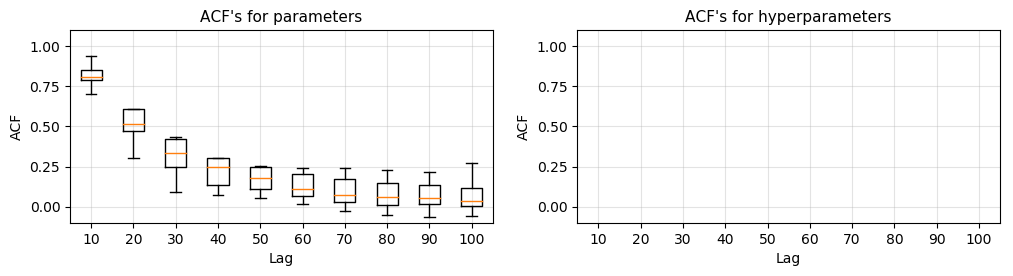

In [43]:
fig = figure("pyplot_subplot_mixed", figsize=(12,2.5))

a, b = -0.1, 1.1
subplot(121)
boxplot(acfs_xi, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:maxlag/freq, store)
ylim([a,b])
title("ACF's for parameters", fontsize=11)

subplot(122)
boxplot(acfs_alpha, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:maxlag/freq, store)
ylim([a,b])
title("ACF's for hyperparameters", fontsize=11);

In [45]:
size(alpha_samples_gzz)

(20, 10000)

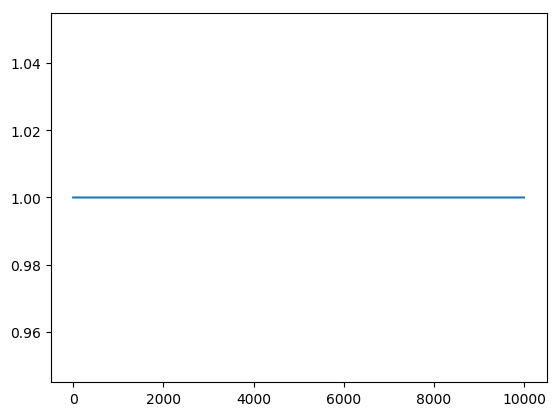

In [48]:
plot(alpha_samples_gzz[10,:]);